In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **IMPORTING REQIRED LIBRARIES**

In [2]:
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced visualizations
import os  # For operating system functionalities like file paths
import cv2  # For image processing
import tensorflow as tf  # Core library for building ML models
from tensorflow import keras  # High-level neural network API
from keras.callbacks import EarlyStopping, ModelCheckpoint  # For controlling training
from tensorflow.keras import regularizers  # For adding regularization to layers
from sklearn.metrics import (  # For model evaluation
    confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from tqdm import tqdm  # For showing progress bars
import warnings  # For handling warnings

# Suppress warnings for cleaner output during development
warnings.filterwarnings('ignore')


# **DATASET**

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Define the path to the dataset
image_data = Path('/content/drive/MyDrive/BACKUPS/Datasets/XrayDataset')

# Get a list of all image file paths in the dataset
train_files = list(image_data.glob('**/*.*'))  # Get all image files in subdirectories
np.random.shuffle(train_files)  # Shuffle the file paths

# Extract labels from the directory structure using pathlib
train_labels = [path.parent.name for path in train_files]

# Create a zip object containing file paths and corresponding labels
train_data = zip(train_files, train_labels)

# Convert the data into a pandas DataFrame
train_df = pd.DataFrame(train_data, columns=["Image", "Label"])

# Display the resulting DataFrame (Optional)
print(train_df.head())  # Display only the first few rows for verification


                                               Image         Label
0  /content/drive/MyDrive/BACKUPS/Datasets/XrayDa...     PNEUMONIA
1  /content/drive/MyDrive/BACKUPS/Datasets/XrayDa...       COVID19
2  /content/drive/MyDrive/BACKUPS/Datasets/XrayDa...       COVID19
3  /content/drive/MyDrive/BACKUPS/Datasets/XrayDa...   NORMAL XRAY
4  /content/drive/MyDrive/BACKUPS/Datasets/XrayDa...     PNEUMONIA


# **VISUALISING THE DATA**

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize label distribution
def plot_label_distribution(dataframe, label_column, title="Label Distribution with Percentages", palette_name="pastel"):
    try:
        # Set a theme for better aesthetics
        sns.set_theme(style="whitegrid")

        # Calculate counts and percentages for each label
        label_counts = dataframe[label_column].value_counts()
        label_percentages = (label_counts / label_counts.sum() * 100).round(2)  # Calculate percentage

        # Print percentage for each label (optional)
        print("Label Percentages:")
        print(label_percentages)

        # Sort the labels based on count values in descending order
        sorted_labels = label_counts.index

        # Create a color palette for the bars
        palette = sns.color_palette(palette_name, len(sorted_labels))

        # Plot the count plot with sorted labels
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(x=dataframe[label_column], order=sorted_labels, palette=palette)

        # Annotate each bar with the percentage value
        for bar in ax.patches:
            height = bar.get_height()  # Get the height of the bar
            percentage = f'{(height / label_counts.sum()) * 100:.2f}%'  # Calculate percentage
            ax.annotate(percentage,  # The label to be annotated
                        (bar.get_x() + bar.get_width() / 2., height),  # Position of the label
                        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

        # Rotate x-axis labels for better visibility and set the label font size
        plt.xticks(rotation=0, ha='center', fontsize=12)

        # Add title and labels with improved fonts and padding
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel("Labels", fontsize=14, labelpad=10)
        plt.ylabel("Count", fontsize=14, labelpad=10)

        # Remove the top and right spines for a cleaner look
        sns.despine()

        # Show the plot with adjusted layout
        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"Error: The label column '{label_column}' is not present in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")



**Visualising training dataframe**

Label Percentages:
Label
PNEUMONIA           38.59
 NORMAL XRAY        34.02
TURBERCULOSIS       14.95
COVID19             12.30
XrayDataset          0.04
xraysecond_model     0.04
variables            0.04
Name: count, dtype: float64


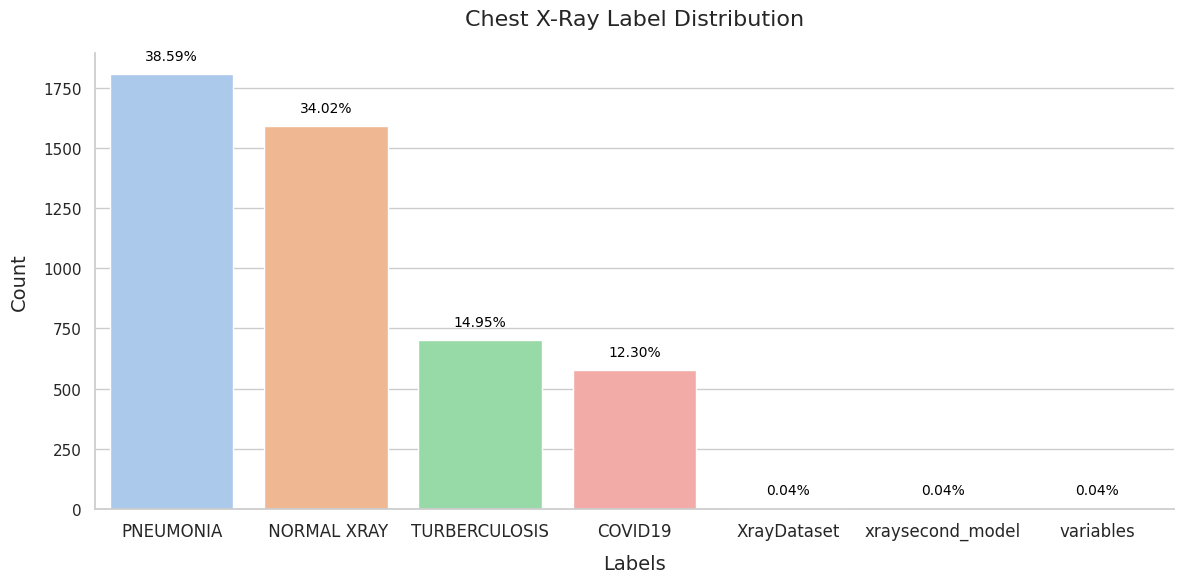

In [5]:
plot_label_distribution(train_df, label_column="Label", title="Chest X-Ray Label Distribution")


# **SPLITING DATA INTO TRAINING & VALIDATION SET**

**VARIABLES**

In [6]:
train_data_dir = image_data
batch_size = 8
target_size = (224, 224)
validation_split = 0.25  # Total split for validation + test
seed = 100


**LOAD TRAINING DATASET**

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=target_size,
    batch_size=batch_size,
)

Found 4676 files belonging to 5 classes.
Using 3507 files for training.


**VALIDATION & TEST DATASET**

In [8]:
val_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=target_size,
    batch_size=batch_size,
)

Found 4676 files belonging to 5 classes.
Using 1169 files for validation.


**SPLITTING VALIDATION & TEST DATASET**

In [9]:
val_size = len(val_test_dataset) // 2  # Split validation and test equally
validation_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

**CALCULATING SAMPLE COUNTS**

In [10]:
train_samples = len(train_dataset) * batch_size
val_samples = len(validation_dataset) * batch_size
test_samples = len(test_dataset) * batch_size

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: {test_samples}")


Training samples: 3512
Validation samples: 584
Test samples: 592


**VISUALIZING THE DATASET DISTRIBUTION**

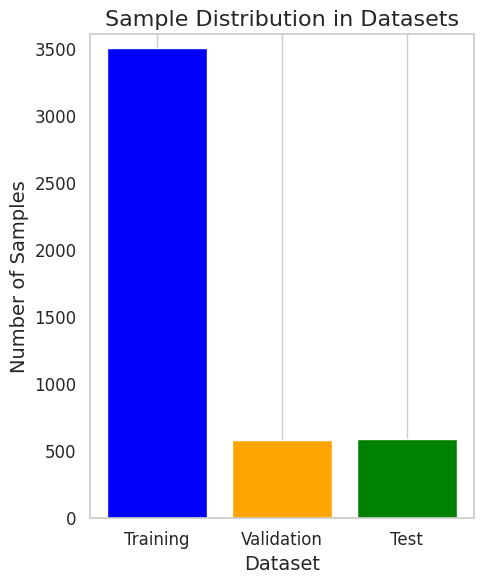

In [11]:
# Names for the datasets
datasets = ['Training', 'Validation', 'Test']
sample_counts = [train_samples, val_samples, test_samples]

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(datasets, sample_counts, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Sample Distribution in Datasets', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(sample_counts) + 100)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

**EXPLORING THE DATASET**

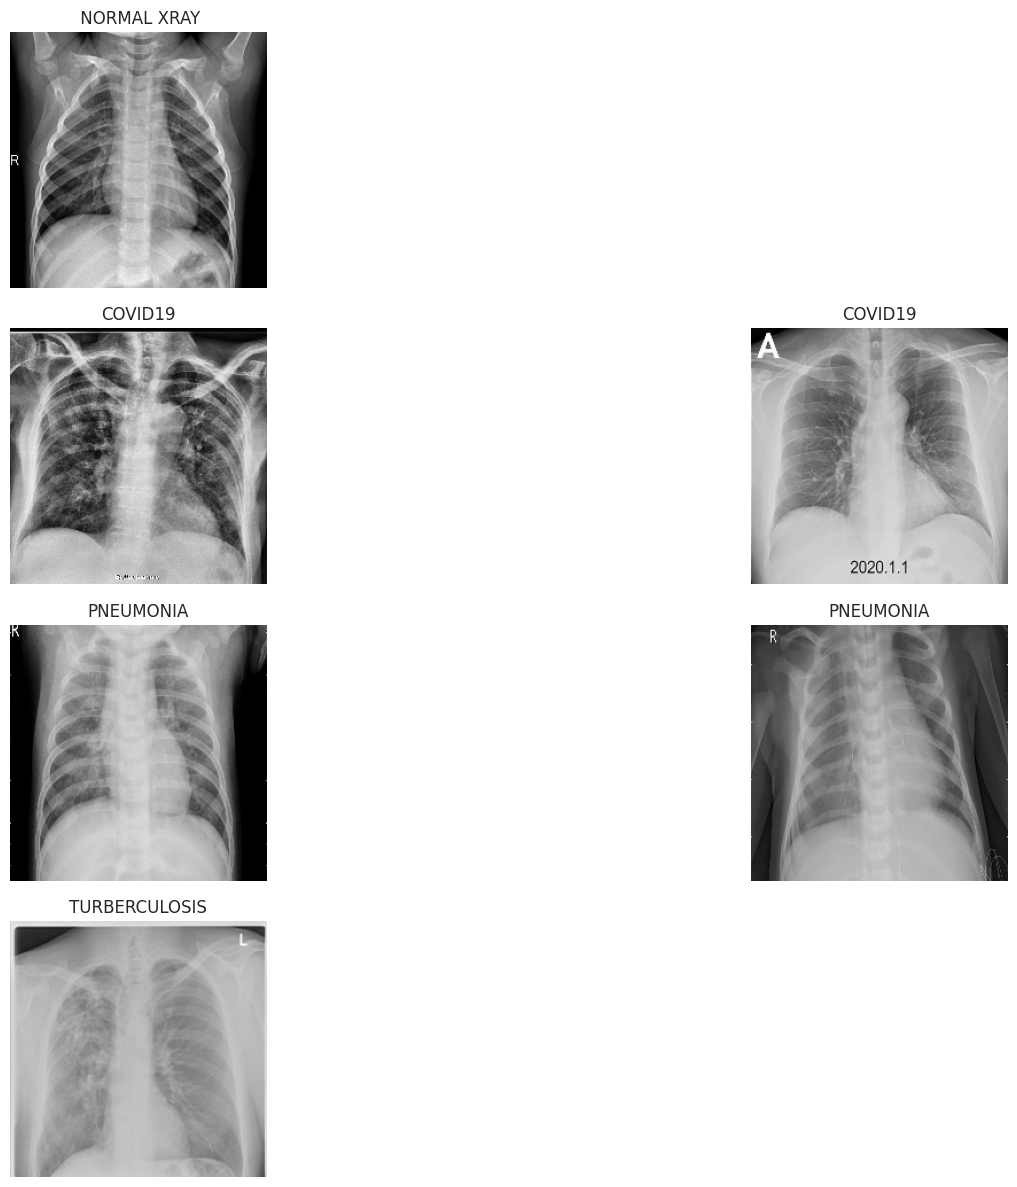

In [12]:
# Extract class names and configure plot dimensions
class_names = train_dataset.class_names
num_images_per_class = 2
num_classes = len(class_names)

# Initialize a dictionary to track displayed image counts per class
count = {class_name: 0 for class_name in class_names}

# Create the plot with dynamic size
plt.figure(figsize=(15, num_classes * 3))  # Adjusted height dynamically based on number of classes

# Loop through the dataset to display images
for images, labels in train_dataset.take(1):
    # Loop through each image and its corresponding label
    for i in range(len(labels)):
        label = class_names[labels[i].numpy()]  # Convert label tensor to NumPy for indexing
        # Check if the required number of images has been displayed for the current class
        if count[label] < num_images_per_class:
            # Calculate the position of the subplot (dynamically arranged)
            subplot_position = count[label] + 1 + num_images_per_class * class_names.index(label)
            ax = plt.subplot(num_classes, num_images_per_class, subplot_position)

            # Display the image with the correct title
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.set_title(label, fontsize=12)
            ax.axis("off")  # Remove axis ticks and labels

            # Update the counter for the class
            count[label] += 1

        # Break the loop when all required images for each class are displayed
        if sum(count.values()) >= num_images_per_class * num_classes:
            break

# Adjust layout for better spacing and show the plot
plt.tight_layout()
plt.show()


# **MODELING**

In [13]:
# Load the base model
base_model = tf.keras.applications.ConvNeXtTiny(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')

# Freeze layers until the last few blocks of the base model
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

# Create the Keras model
keras_model = keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.GlobalAveragePooling2D())
keras_model.add(keras.layers.Dense(256, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
keras_model.add(keras.layers.BatchNormalization())
keras_model.add(keras.layers.Activation('relu'))
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(4, activation=tf.nn.softmax))

# Print the model summary
keras_model.summary()

# Compile the model with an optimizer, loss, and metrics
keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Use lower learning rate
                    loss='categorical_crossentropy',  # For multi-class classification
                    metrics=['accuracy'])

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)           │ (None, 7, 7, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,019,044 (106.88 MB)

 Trainable params: 14,449,412 (55.12 MB)

 Non-trainable params: 13,569,632 (51.76 MB)

# **TRAINING**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model with optimizer, learning rate, and loss
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
keras_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = keras_model.fit(train_dataset, validation_data=validation_dataset,
                          epochs=10, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test dataset
test_loss, test_accuracy = keras_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 1711s 4s/step - accuracy: 0.4429 - loss: 1.7418 - val_accuracy: 0.8596 - val_loss: 0.8102 - learning_rate: 1.0000e-05
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - accuracy: 0.7560 - loss: 1.0334 - val_accuracy: 0.9024 - val_loss: 0.6558 - learning_rate: 1.0000e-05
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - accuracy: 0.8421 - loss: 0.8422 - val_accuracy: 0.9161 - val_loss: 0.6002 - learning_rate: 1.0000e-05
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 72s 139ms/step - accuracy: 0.8713 - loss: 0.7560 - val_accuracy: 0.9281 - val_loss: 0.5713 - learning_rate: 1.0000e-05
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - accuracy: 0.9043 - loss: 0.6873 - val_accuracy: 0.9418 - val_loss: 0.5464 - learning_rate: 1.0000e-05
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - accuracy: 0.9088 - loss: 0.6417 - val_accuracy: 0.9418 - val_loss: 0.5309 - learning_rate: 1.0000e-05
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 139

**SAVING THE TRAINED MODEL**

In [ ]:
# Save the trained model
keras_model.save('/content/drive/MyDrive/BACKUPS/Datasets/XrayDataset/xray_model.h5')


In [ ]:
# Save the trained model
keras_model.save('/content/drive/MyDrive/BACKUPS/Datasets/XrayDataset/xray_model.keras')


In [ ]:
keras_model.export('/content/drive/MyDrive/BACKUPS/Datasets/XrayDataset/xraysecond_model')  # SavedModel format

Saved artifact at '/content/drive/MyDrive/BACKUPS/Datasets/XrayDataset/xraysecond_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_552')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134802709043984: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134802710812752: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134802709165536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802709350880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802709352992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802709354224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802709360384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802709353520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802709358272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1348027093

# **EVALUATION**

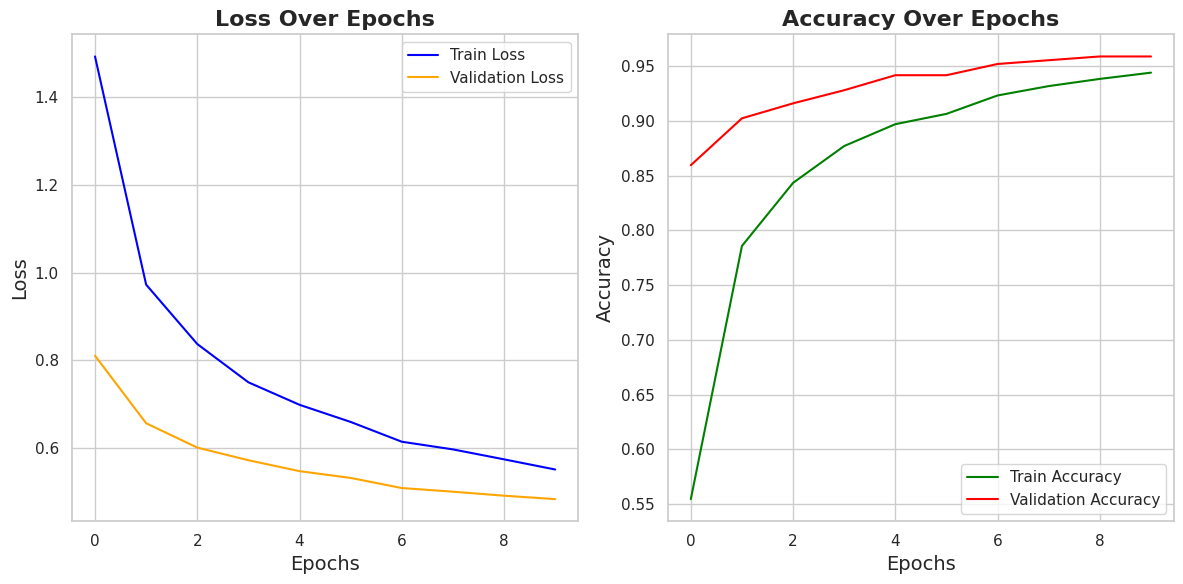

In [16]:
hist_=pd.DataFrame(history.history)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs', fontsize=16, weight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs', fontsize=16, weight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
score, acc = keras_model.evaluate(test_dataset)
print('Test Loss =', score)
print('Test Accuracy =', acc)

74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.9449 - loss: 0.4882
Test Loss = 0.49765655398368835
Test Accuracy = 0.9538461565971375


**RESULTS**

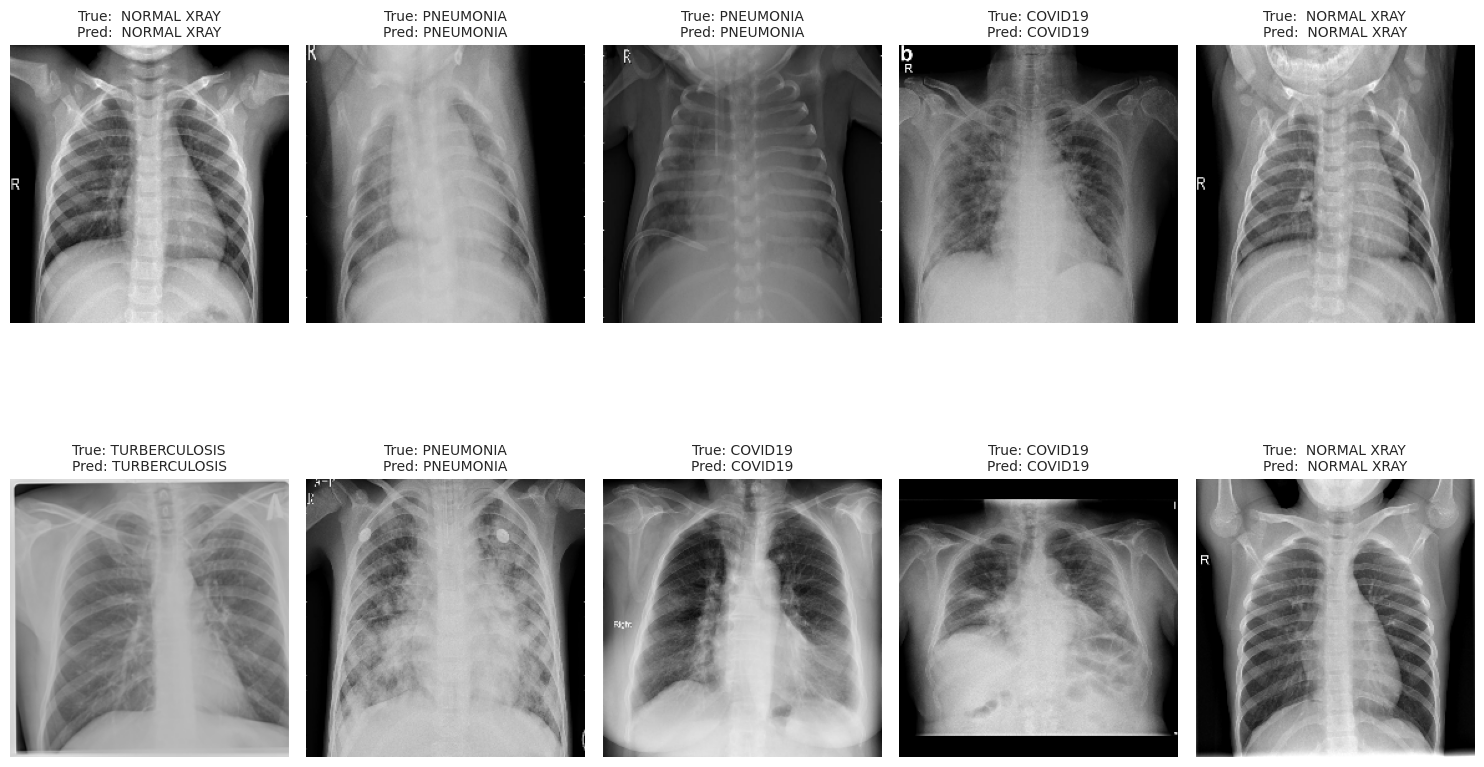

In [18]:
# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Initialize a list to store images for visualization
images_for_display = []

# Iterate through the validation dataset to extract true labels and predictions
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())
    preds = keras_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

    # Store images and labels for display
    images_for_display.extend(images.numpy())

# Convert the lists to NumPy arrays for further processing
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the number of images to display
num_images_to_display = 10
num_images_available = min(num_images_to_display, len(images_for_display))

plt.figure(figsize=(15, 10))

# Plot images with their true and predicted labels
for i in range(num_images_available):
    ax = plt.subplot(2, 5, i + 1)  # Create a 2-row, 5-column grid
    plt.imshow(images_for_display[i].astype("uint8"))
    true_label = class_names[y_true[i]]
    predicted_label = class_names[y_pred[i]]
    plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()